# 4회차: 비모수 검정, 카이제곱 검정

## 목차

| 순서 | 파트   | 주제                     | 핵심 내용                                                |
|------|--------|--------------------------|----------------------------------------------------------|
| 1    | Part 1 | 검정 방법 선택 가이드    | 용어표, 의사결정 프레임워크, Q-Q Plot 해석, 가정 검정     |
| 2    | Part 2 | 비모수 검정              | Wilcoxon signed-rank, Mann-Whitney U, 모수/비모수 비교    |
| 3    | Part 3 | 카이제곱 검정            | 적합도 검정, 독립성 검정, Cramér's V, 기대빈도            |

> **실습 과제**는 별도 파일 `practice_04_assignment.ipynb`에 있습니다.

### 14시 30분에 1시간 만더!!
### 4회차는 오늘 끝낼것
### 14시 30분 필수가 아님!!! (ZEP에서 하겠음!)
### 3회차 과제 기한 !! 언제? 모든 과제를 설날 끝나기전까지!!! 
### 3,4,5,6회차!!!! ---> 전부 설날 끝나기전까지 하세요!!
#### 안한다고 뭐 불이익은 없지만 스스로에게 불이익 ---> 실력이 자신 있으면 하지 마시고, 실력을 키우겠다 하면 하시고!!

## Part 1: 검정 방법 선택

### 1.1 주요 용어 정리

| 용어           | 영어                          | 정의                                                       |
|----------------|-------------------------------|------------------------------------------------------------|
| 모수 검정      | Parametric Test               | 모집단이 특정 분포(예: 정규분포)를 따른다는 가정 하에 수행하는 검정 |
| 비모수 검정    | Nonparametric Test            | 모집단 분포에 대한 가정 없이 수행하는 통계 검정             |
| Q-Q Plot       | Quantile-Quantile Plot        | 데이터 분위수와 이론적 분위수를 비교하여 분포를 시각적으로 확인 |
| 카이제곱 검정  | Chi-square Test               | 카이제곱 분포를 이용하여 범주형 데이터를 분석하는 검정 (적합도·독립성 등) |
| 분산분석       | Analysis of Variance (ANOVA)  | 3개 이상 집단의 평균 차이를 검정하는 방법                   |
| 사후검정       | Post-hoc Test                 | ANOVA에서 유의한 결과가 나온 후 어떤 집단 쌍이 다른지 확인  |
| 사후분석       | Post-hoc Analysis             | 카이제곱 검정에서 유의한 결과가 나온 후 어떤 셀이 기대와 다른지 확인 (잔차 분석) |

# 쉬는 시간 갖고 12 : 17분에 이어서 하겠습니다.

In [3]:
# ── 필수 라이브러리 Import ──
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations
from matplotlib.patches import Patch
import warnings
import platform

warnings.filterwarnings('ignore')

# ── 운영체제별 한글 폰트 설정 ──
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 전역 시드 설정 (재현성을 위해)
np.random.seed(42)

print("=" * 60)
print("라이브러리 로드 완료!")
print("한글 폰트 설정 완료!")
print("=" * 60)

라이브러리 로드 완료!
한글 폰트 설정 완료!


### 1.2 검정 선택 의사결정

#### 연속형 변수

| 검정                 | 정규성 확인  | 등분산 확인 | 모수 검정 (가정 만족)             | 등분산만 위반   | 비모수 검정 (정규성 위반)          | 사후검정                | 효과크기      |
|----------------------|-------------|------------|----------------------|----------------|---------------------|----------------------------|---------------|
| 단일표본              | Q-Q Plot<br>Shapiro-Wilk | —          | 단일표본 t            | —              | Wilcoxon signed-rank | —                          | 모수 → Cohen's d<br>비모수 → rank-biserial r |
| 대응표본 (전후)       | Q-Q Plot<br>Shapiro-Wilk<br>(차이값) | —          | 대응표본 t            | —              | Wilcoxon signed-rank | —                          | 모수 → Cohen's d<br>비모수 → rank-biserial r |
| 독립 2집단            | Q-Q Plot<br>Shapiro-Wilk | Levene     | Student's t           | Welch's t      | Mann-Whitney U       | —                          | 모수 → Cohen's d<br>비모수 → rank-biserial r |
| 독립 3집단+           | Q-Q Plot<br>Shapiro-Wilk | Levene     | One-way ANOVA         | Welch's ANOVA  | Kruskal-Wallis       | Tukey / GH* / Dunn** | ANOVA → η² / ω²†<br>Welch → η² / ω²†<br>KW → η²_H |

> \* GH = Games-Howell (Welch's ANOVA 사후검정) &nbsp;&nbsp; \*\* Dunn = Dunn test (Kruskal-Wallis 사후검정) \
> **실무 팁**: 3집단+ 비교에서는 전체 효과크기(η²)보다 **사후검정의 쌍별 Cohen's d**가 실질적으로 더 중요합니다. \
> **참고**: 정규성 위반 시 비모수 검정을 사용하며, 이 경우 등분산 확인은 불필요합니다. \
> **† η² vs ω²**: η²(에타제곱)은 집단 간 분산이 전체 분산에서 차지하는 비율입니다. 다만 소표본에서 **과대추정 경향**이 있어, 편향을 보정한 **ω²(오메가제곱)** 를 논문에서는 권장합니다. 표본이 커질수록 두 값은 수렴하므로 대표본에서는 차이가 미미합니다.

#### 범주형 변수

| 검정               | 기대빈도 조건 충족          | 기대빈도 조건 불충족              | 사후분석       | 효과크기    |
|--------------------|----------------------|-------------------------------|---------------|------------|
| 빈도 적합성         | 카이제곱 적합도        | Monte Carlo 시뮬레이션          | 잔차 분석      | Cohen's w  |
| 변수 독립성 (2×2)   | 카이제곱 독립성        | Fisher 정확검정                 | 오즈비 (필요 시) | φ (phi)    |
| 변수 독립성 (R×C)   | 카이제곱 독립성        | 범주 병합 또는 Fisher-Freeman-Halton | 잔차 분석  | Cramér's V |
> **Cochran 규칙**: 기대빈도 < 5인 셀이 전체의 20%를 초과하거나, 기대빈도 < 1인 셀이 하나라도 있으면 카이제곱 근사가 부정확합니다.
> - **적합도 검정**: 정확검정이 없으므로 **Monte Carlo 시뮬레이션**이 유일한 대안입니다
> - **독립성 검정 (2×2)**: **Fisher 정확검정**을 사용합니다
> - **독립성 검정 (R×C)**: 범주 병합을 우선 시도하고, 병합이 부적절하면 **Fisher-Freeman-Halton 검정**(`scipy.stats.fisher_exact()`, scipy 1.7+)을 사용합니다
>
> **범주 병합(collapsing categories)**: 기대빈도가 낮은 범주를 인접한 범주와 합쳐 기대빈도 조건을 충족시키는 방법입니다.
> - 병합은 **이론적으로 유사한 범주** 간에만 수행해야 합니다 (예: "매우 불만족"+"불만족" → "불만족 이하")
> - 단순히 빈도를 채우기 위해 의미가 다른 범주를 합치면 해석이 왜곡됩니다
> - 병합 후에도 조건이 충족되지 않으면 Fisher-Freeman-Halton 검정을 사용합니다

### 1.3 정규성 검정

#### Shapiro-Wilk 검정 (수치적 판단)

가장 널리 사용되는 정규성 검정입니다. W 통계량이 1에 가까울수록 정규분포에 가깝습니다.

| 결과 | 해석 | 다음 단계 |
|------|------|----------|
| p > 0.05 | 정규성을 **기각하지 못함** | 모수 검정 사용 고려 |
| p ≤ 0.05 | 정규성 **기각** | 비모수 검정 또는 변환 고려 |

> **주의**: p > 0.05는 "정규분포가 맞다"는 뜻이 아니라 "정규분포를 기각할 근거가 부족하다"는 뜻입니다.

> **한계**: 표본이 크면(n > 50) 사소한 편차에도 유의하게 나옵니다. 
> 표본이 작으면(n < 20) 상당히 비정규적이어도 기각하지 못할 수 있습니다. \
> 따라서 **Q-Q Plot과 함께** 판단하는 것이 중요합니다.

#### Q-Q Plot 해석 (시각적 판단)

**Q-Q Plot (Quantile-Quantile Plot)** 은 데이터의 분위수를 이론적 정규분포의 분위수와 비교하는 그래프입니다. \
점들이 대각선 위에 놓이면 정규분포를 따르고, 벗어나는 **방향과 패턴**으로 분포 특성을 파악합니다.

| 패턴         | Q-Q Plot 모양            | 해석                                | 대응 방법              |
|:------------:|:------------------------:|-------------------------------------|-----------------------|
| **Normal**       | 직선 (⟋)              | 정규분포를 따릅니다                 | 변환 불필요            |
| **Right-skew**   | 위로 휨 (∪)        | 오른쪽 꼬리가 깁니다 (양의 왜도)    | `log`, `sqrt` 변환     |
| **Left-skew**    | 아래로 휨 (∩)      | 왼쪽 꼬리가 깁니다 (음의 왜도)      | 제곱, 지수 변환        |
| **Light-tailed** | S자 (양끝 ↓)      | 꼬리가 정규분포보다 얇습니다        | 특별한 변환 불필요     |
| **Heavy-tailed** | 역S자 (양끝 ↑)    | 꼬리가 정규분포보다 두껍습니다      | 이상치 제거 또는 비모수 |
| **Bimodal**      | 두 곡선 + 중간 갭  | 봉우리가 2개입니다 (두 군집)        | 군집 분리 후 분석      |

> **팁**: Shapiro-Wilk(수치) + Q-Q Plot(시각)을 함께 사용하세요. 
> 두 결과가 불일치하면 **Q-Q Plot을 우선** 판단합니다 — 시각적 패턴이 더 정보가 풍부합니다.

<img src="images/pr_04/QQ_Plot_패턴_가이드.png" width="100%">

### 1.4 효과크기(Effect Size) 정리

> **효과크기**는 p-value와 별개로, 차이나 관계의 **실질적 크기**를 나타냅니다.
> p-value는 표본 크기에 크게 좌우되지만, 효과크기는 상대적으로 안정적이므로 **반드시 함께 보고**합니다.

#### 연속형 — 단일·2집단 비교

| 효과크기 | 적용 검정 | 공식 | 공식 의미 | Python 라이브러리 | 해석 기준 (small / medium / large) |
|----------|----------|------|----------|-------------------|--------------------------------------|
| **Cohen's d**<br>(단일표본) | 단일표본 t | (M − μ₀) / S | 평균 차이가 **표준편차 몇 개분**인가 | `(x.mean() - mu0) / x.std(ddof=1)` | 0.2 / 0.5 / 0.8 |
| **Cohen's d**<br>(대응표본) | 대응표본 t | M_diff / S_diff | 차이값의 평균이 **차이값의 표준편차의 몇 개분**인가 | `diff.mean() / diff.std(ddof=1)` | 0.2 / 0.5 / 0.8 |
| **Cohen's d**<br>(독립표본) | Student's t<br>Welch's t | (M₁ − M₂) / S_pooled | 두 집단 평균 차이가 **통합 표준편차의 몇 개분**인가 | `pg.compute_effsize(x, y, eftype='cohen')` | 0.2 / 0.5 / 0.8 |
| **rank-biserial r** | Wilcoxon signed-rank<br>(단일표본) | (W⁺ − W⁻) / (W⁺ + W⁻) | 양의 순위합과 음의 순위합의 **상대적 우세 정도** (−1~+1) | `pg.wilcoxon(x - mu0)['RBC']` | 0.1 / 0.3 / 0.5 |
| **rank-biserial r** | Mann-Whitney U | 1 − 2U / (n₁ · n₂) | 모든 쌍별 비교에서 한 집단이 **우세한 정도** (−1~+1) | `pg.mwu(x, y)['RBC']` | 0.1 / 0.3 / 0.5 |
| **rank-biserial r** | Wilcoxon signed-rank | (W⁺ − W⁻) / (W⁺ + W⁻) | 양의 순위합과 음의 순위합의 **상대적 우세 정도** (−1~+1) | `pg.wilcoxon(x, y)['RBC']` | 0.1 / 0.3 / 0.5 |

#### 연속형 — 3집단+ 비교

| 효과크기 | 적용 검정 | 공식 | 공식 의미 | Python 라이브러리 | 해석 기준 (small / medium / large) |
|----------|----------|------|----------|-------------------|--------------------------------------|
| **η²** (에타제곱) | One-way ANOVA<br>Welch's ANOVA | SS_B / SS_T | 전체 변동 중 **집단 간 차이가 설명하는 비율** (0~1) | `pg.anova(dv, between, data)['np2']` | 0.01 / 0.06 / 0.14 |
| **ω²** (오메가제곱) | One-way ANOVA<br>(η² 대신 권장) | (SS_B − df_B · MS_W) / (SS_T + MS_W) | η²의 **편향 보정 버전** — 소표본 과대추정 보정 (0~1) | 수동 계산 | 0.01 / 0.06 / 0.14 |
| **η²_H** | Kruskal-Wallis | (H − k + 1) / (N − k)† | η²의 **비모수 버전** — 순위 기반 분산 설명 비율 (0~1) | 수동 계산 | η²와 동일 기준 적용 |

> **η² vs ω²**: η²는 소표본에서 과대추정 경향이 있으므로, 논문에서는 편향 보정된 ω²를 권장합니다. \
> **† η²_H 공식**: Tomczak & Tomczak (2014) 기준입니다. 일부 문헌에서는 ε² = H / (N − 1) 을 사용하기도 합니다. 실제 값 차이는 미미하지만, 출처에 따라 공식이 다를 수 있으므로 사용 공식을 명시하는 것이 좋습니다.

#### 범주형 변수

| 효과크기 | 적용 검정 | 공식 | 공식 의미 | Python 라이브러리 | 해석 기준 (small / medium / large) |
|----------|----------|------|----------|-------------------|--------------------------------------|
| **Cohen's w** | 카이제곱 적합도 | √(χ² / N) | 관측 빈도와 기대 빈도의 **표준화된 괴리 정도** (0~∞) | `np.sqrt(chi2 / n)` | 0.1 / 0.3 / 0.5 |
| **Cramér's V** | 카이제곱 독립성 | √(χ² / (N · min(r−1, c−1))) | 두 범주형 변수 간 **연관성의 강도** (0~1) | `association(ct.values, method='cramer')` | df*에 따라 다름 † |

> † **Cramér's V 해석 기준** (Cohen 관례) \
> Small = 0.1/√df*, Medium = 0.3/√df*, Large = 0.5/√df* \
> (df* = min(r−1, c−1))
> | df* | Small | Medium | Large |
> |-----|-------|--------|-------|
> | 1 (2×2) | 0.10 | 0.30 | 0.50 |
> | 2 | 0.07 | 0.21 | 0.35 |
> | 3 | 0.06 | 0.17 | 0.29 |
>
> 논문에서는 2×2의 효과크기 결과를 φ로 표기하는 경우가 많습니다.

**실무 팁**: 
- 단일·2집단 비교에서는 효과크기가 곧 결론의 핵심입니다. 
- 반면 3집단+ 비교에서는 전체 효과크기(η²)보다 **사후검정의 쌍별 Cohen's d**가, 
- 범주형에서는 Cramér's V보다 **조정된 잔차 분석**(어느 셀이 기대와 다른가)이 실질적으로 더 중요합니다.

### 1.5 가정 검정 실습

> 통계 분석은 **분석 목적 명확화 → 가정 확인 → 검정 수행** 순서로 진행합니다.

#### 시나리오 1: 단일표본 검정 — 카페 대기 시간

**상황**: 어느 카페 체인의 전국 평균 대기 시간은 **5분**입니다. \
한 지점에서 25명의 대기 시간을 조사하여, 이 지점의 대기 시간이 전국 평균과 다른지 검정하려 합니다. \

In [ ]:
# ── 시나리오 1: 단일표본 가정 검정 — 카페 대기 시간 ──
print("[시나리오 1] 단일표본 가정 검정 — 카페 대기 시간")
print("=" * 60)

# 표본 추출
np.random.seed(100)
wait_time = np.round(np.random.exponential(scale=5, size=25) + 2, 1)
mu0 = 5.0  # 전국 평균 대기 시간(분)

print(f"  표본 크기: {len(wait_time)}명")
print(f"  전국 평균(μ₀): {mu0}분")
print(f"  표본 평균: {wait_time.mean():.1f}분")
print(f"  표본 중앙값: {np.median(wait_time):.1f}분")

# ── Shapiro-Wilk 정규성 검정 ──
stats_sw1, p_sw1 = stats.shapiro(wait_time)
print(p_sw1) #0.00067
# 결론 : 정규성을 기각!

[시나리오 1] 단일표본 가정 검정 — 카페 대기 시간
  표본 크기: 25명
  전국 평균(μ₀): 5.0분
  표본 평균: 6.8분
  표본 중앙값: 4.8분
0.0006714181600639546


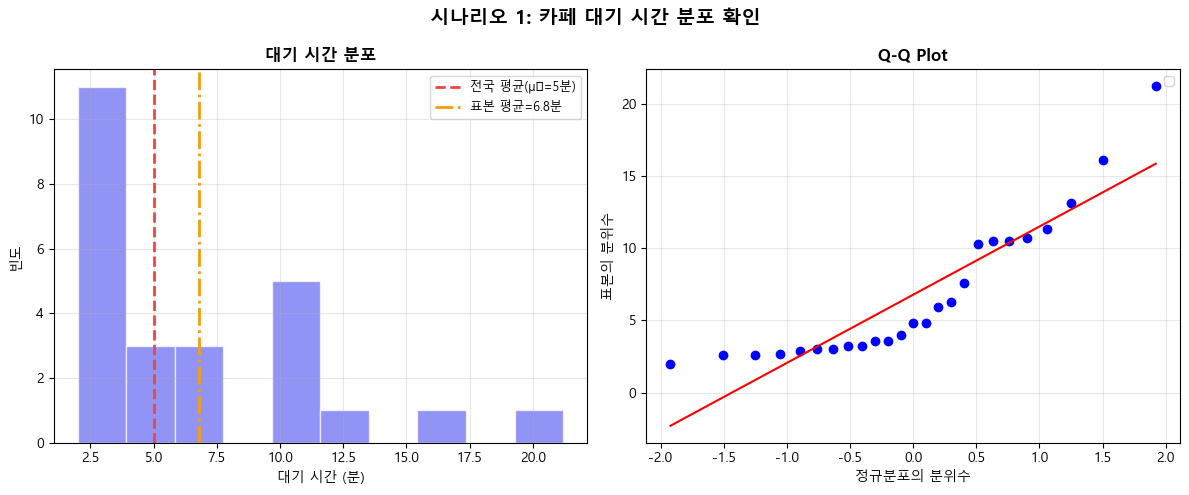

In [ ]:
# ── 시나리오 1: 히스토그램 + Q-Q Plot ──
fig, axes = plt.subplots(1, 2, figsize=(12, 5)) #1행 2열
fig.suptitle("시나리오 1: 카페 대기 시간 분포 확인", fontsize=14, fontweight="bold")

# 히스토그램
axes[0].hist(wait_time, bins=10, color="#6366F1", alpha=0.7, edgecolor="white")
axes[0].axvline(mu0, color="#EF4444", linestyle="--", linewidth=2,
                label=f"전국 평균(μ₀={mu0:.0f}분)")
axes[0].axvline(wait_time.mean(), color="#F59E0B", linestyle="-.", linewidth=2,
                label=f"표본 평균={wait_time.mean():.1f}분")
axes[0].set_title("대기 시간 분포", fontsize=12, fontweight="bold")
axes[0].set_xlabel("대기 시간 (분)")
axes[0].set_ylabel("빈도")
axes[0].legend(fontsize=9)
axes[0].grid(alpha=0.3)


# Q-Q plot
stats.probplot(wait_time, dist='norm', plot=axes[1]) #2번쨰 열에 그림
axes[1].set_title("Q-Q Plot", fontsize=12, fontweight="bold")
axes[1].set_xlabel("정규분포의 분위수")
axes[1].set_ylabel("표본의 분위수")
axes[1].legend(fontsize=9)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
# U : 모양에 가까움 --> 양의 왜도 (로그변환, 루트변환 고려)

In [ ]:
# ── 시나리오 1: 검정 방법 선택 + 효과크기 ──
# 정규분포를 안따름
# 어떤 검정 방법? wilcoxon 부호 순위 검정
w_stats, p_val = stats.wilcoxon(wait_time - mu0)
print(p_val) #0.3672 --> 귀무가설 지지

# 비모수 효과크기 : rank-bserial r
import pingouin as pg 
# uv add pingouin
# uv sync 



0.36725538198088536


#### 시나리오 2: 대응표본 검정 — 수면 앱 효과

**상황**: 새로운 수면 앱의 효과를 검증하기 위해 20명의 **사용 전후 수면 시간**을 비교하려고 합니다. \
대응표본 t-검정을 사용하려면 **차이값(전후 차이)의 정규성**을 먼저 확인해야 합니다.

In [ ]:
# ── 시나리오 2: 대응표본 가정 검정 ──
print("[시나리오 2] 대응표본 가정 검정 — 수면 앱 효과 검증")
print("=" * 60)

# 표본 추출
np.random.seed(200)
before_sleep = np.round(np.random.normal(6.0, 1.2, 20), 1)
after_sleep = before_sleep + np.round(np.random.normal(0.8, 0.6, 20), 1)  # 평균 0.8시간 증가
diff_sleep = after_sleep - before_sleep

print(f"  참가자 수: {len(before_sleep)}명")
print(f"  사용 전 평균 수면: {before_sleep.mean():.1f}시간")
print(f"  사용 후 평균 수면: {after_sleep.mean():.1f}시간")
print(f"  평균 차이: {diff_sleep.mean():.2f}시간")

# ── 1) Shapiro-Wilk 정규성 검정 (차이값) ──

In [ ]:
# ── 두 집단 분포 확인 (히스토그램) ──
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))
fig.suptitle("수면 시간 분포 비교 — 사용 전 vs 사용 후", fontsize=14, fontweight="bold")

# 사용 전
axes[0].hist(before_sleep, bins=8, color="#6366F1", alpha=0.7, edgecolor="white")
axes[0].axvline(before_sleep.mean(), color="#EF4444", linestyle="--",
                label=f"평균={before_sleep.mean():.1f}")
axes[0].set_title("사용 전 수면 시간", fontsize=12, fontweight="bold")
axes[0].set_xlabel("수면 시간 (시간)")
axes[0].set_ylabel("빈도")
axes[0].legend()
axes[0].grid(alpha=0.3)

# 사용 후
axes[1].hist(after_sleep, bins=8, color="#14B8A6", alpha=0.7, edgecolor="white")
axes[1].axvline(after_sleep.mean(), color="#EF4444", linestyle="--",
                label=f"평균={after_sleep.mean():.1f}")
axes[1].set_title("사용 후 수면 시간", fontsize=12, fontweight="bold")
axes[1].set_xlabel("수면 시간 (시간)")
axes[1].legend()
axes[1].grid(alpha=0.3)

# 겹쳐 보기
axes[2].hist(before_sleep, bins=8, color="#6366F1", alpha=0.5, edgecolor="white", label="사용 전")
axes[2].hist(after_sleep, bins=8, color="#14B8A6", alpha=0.5, edgecolor="white", label="사용 후")
axes[2].axvline(before_sleep.mean(), color="#6366F1", linestyle="--", alpha=0.8)
axes[2].axvline(after_sleep.mean(), color="#14B8A6", linestyle="--", alpha=0.8)
axes[2].set_title("분포 비교 (겹침)", fontsize=12, fontweight="bold")
axes[2].set_xlabel("수면 시간 (시간)")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ── Q-Q Plot (차이값) ──

In [ ]:
# ── 2) 검정 방법 선택 ──


### 흔한 오해

#### "표본이 크면 정규성 검정 불필요하다?"  

CLT(중심극한정리) 덕분에 **평균 기반 검정(t-검정·ANOVA)** 은 대표본에서 정규성 위반에 강건합니다.  
그러나 이것이 정규성 확인을 *생략해도 된다*는 뜻은 아닙니다.

**대표본의 역설**

- Shapiro-Wilk 검정은 n이 클수록 **과민**해져서, 실질적으로 무의미한 작은 편차도 "비정규"로 판정합니다.
- 반면 t-검정·ANOVA는 대표본에서 정규성 위반에 강건하므로, Shapiro-Wilk가 유의해도 곧바로 비모수로 전환할 필요는 없습니다.

**실무적 권장**

1. **항상 분포를 확인**하되, 대표본에서는 **Q-Q Plot(시각적 판단)** 을 우선합니다.
2. Shapiro-Wilk가 유의하더라도 Q-Q Plot에서 대략 직선이면 → 모수 검정 사용 가능합니다.
3. Q-Q Plot에서도 심하게 벗어나면(극단적 왜도·이상치) → 비모수 검정으로 전환합니다.
4. 정규성과 별개로 **등분산성·독립성** 등 다른 전제 조건은 반드시 점검해야 합니다.

> **주의**: CLT의 강건성은 평균 기반 검정에 한정됩니다. 등분산 검정(Bartlett)이나 상관계수 검정 등은 대표본에서도 비정규성에 민감할 수 있습니다.

### 시나리오 3: 독립표본 검정

**상황**: 두 가지 마케팅 전략(A, B)의 매출 효과를 비교합니다.
매출 데이터는 로그정규분포를 따르므로 정규성 가정이 위반됩니다.


In [ ]:
# ── 시나리오 3: 데이터 생성 + 기술통계 ──
print("\n[시나리오 3] 마케팅 전략 매출 비교")
print("=" * 60)

np.random.seed(200)
# 로그정규분포 활용 샘플 데이터 생성
strategy_a = np.round(np.random.lognormal(mean=4.8, sigma=0.5, size=20), 1) 
strategy_b = np.round(np.random.lognormal(mean=4.9, sigma=0.45, size=18), 1)

print(f"\n전략 A (n={len(strategy_a)}): 평균={np.mean(strategy_a):.1f}, 중앙값={np.median(strategy_a):.1f}")
print(f"전략 B (n={len(strategy_b)}): 평균={np.mean(strategy_b):.1f}, 중앙값={np.median(strategy_b):.1f}")

In [ ]:
# ── 1단계: 분포 시각화 (히스토그램 + 밀도 플롯) ──
from scipy.stats import gaussian_kde

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, data, name, color in [
    (axes[0], strategy_a, '전략 A', '#3B82F6'),
    (axes[1], strategy_b, '전략 B', '#F59E0B')
]:
    ax.hist(data, bins=10, density=True, alpha=0.5, color=color, edgecolor='white', label='히스토그램')
    x_range = np.linspace(data.min() - 10, data.max() + 10, 200)
    kde = gaussian_kde(data)
    ax.plot(x_range, kde(x_range), color=color, linewidth=2, label='밀도 추정 (KDE)')
    ax.set_title(f'{name} 매출 분포', fontsize=13, fontweight='bold')
    ax.set_xlabel('매출 (만원)', fontsize=11)
    ax.set_ylabel('밀도', fontsize=11)
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

fig.suptitle('분포 확인 — 두 집단 모두 오른쪽 꼬리가 긴 비대칭 분포', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 두 전략 매출 결과 비교 ──
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 히스토그램 겹치기
axes[0].hist(strategy_a, bins=10, alpha=0.6, color='#3B82F6',
             label=f'전략 A (중앙값={np.median(strategy_a):.1f})', edgecolor='white')
axes[0].hist(strategy_b, bins=10, alpha=0.6, color='#F59E0B',
             label=f'전략 B (중앙값={np.median(strategy_b):.1f})', edgecolor='white')
axes[0].axvline(np.median(strategy_a), color='#3B82F6', linestyle='--', linewidth=2)
axes[0].axvline(np.median(strategy_b), color='#F59E0B', linestyle='--', linewidth=2)
axes[0].set_xlabel('매출 (만원)', fontsize=12)
axes[0].set_ylabel('빈도', fontsize=12)
axes[0].set_title('마케팅 전략별 매출 분포', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 박스플롯
bp = axes[1].boxplot([strategy_a, strategy_b], labels=['전략 A', '전략 B'],
                      patch_artist=True, widths=0.5)
bp['boxes'][0].set_facecolor('#3B82F6')
bp['boxes'][0].set_alpha(0.6)
bp['boxes'][1].set_facecolor('#F59E0B')
bp['boxes'][1].set_alpha(0.6)
axes[1].set_ylabel('매출 (만원)', fontsize=12)
axes[1].set_title(f'마케팅 전략별 매출 분포', fontsize=13, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# ── 2단계-A: 정규성 검정 (Shapiro-Wilk) ──
# 독립표본 비교에서는 각 집단의 정규성을 따로 확인합니다

In [ ]:
# ── 2단계-B: Q-Q Plot 시각적 확인 ──
# Q-Q Plot: 점들이 빨간 직선 위에 놓이면 정규분포, 벗어나면 비정규
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, data, name, color in [
    (axes[0], strategy_a, "전략 A", "#3B82F6"),
    (axes[1], strategy_b, "전략 B", "#F59E0B")
]:
    # Q-Q Plot 그리기
    stats.probplot(data, dist="norm", plot=ax)

    # 점 색상 설정
    ax.get_lines()[0].set_markerfacecolor(color)
    ax.get_lines()[0].set_markeredgecolor(color)

    # 제목에 Shapiro p-value 표시
    sw_p = stats.shapiro(data).pvalue
    ax.set_title(f"{name} Q-Q Plot (Shapiro p={sw_p:.4f})", fontsize=12, fontweight="bold")
    ax.grid(alpha=0.3)

fig.suptitle("2. 정규성 확인",
             fontsize=13, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
# ── 2단계-C: 등분산 검정 (Levene) + 종합 판단 ──
# 독립 2집단 비교에서는 등분산 가정도 확인합니다

In [ ]:
# ── 3단계: Mann-Whitney U 검정 ──

### 흔한 오해

| 오해 | 진실 |
|------|------|
| "비모수는 항상 모수보다 나쁘다" | 가정 위반 시 비모수가 더 정확합니다 |
"표본이 크면 비모수 불필요" | 대표본에서도 **극단적 이상치**가 있으면 평균·분산이 왜곡되므로, 순위 기반 비모수 검정이 여전히 유용합니다
| "비모수 = 평균 비교" | 순위 기반 '분포 위치 비교'이며, 동일 분포 형태 가정 하에서만 중앙값 비교로 해석할 수 있습니다 |

---

## Part 3: 카이제곱 검정

### 카이제곱 검정의 핵심 개념

#### 검정 통계량

$$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$$

- $O_i$: 관측 빈도 (Observed Frequency)

- $E_i$: 기대 빈도 (Expected Frequency)

#### 자유도

- **적합도 검정**: $df = k - 1$ (k: 범주 수)

- **독립성 검정**: $df = (r-1)(c-1)$ (r: 행 수, c: 열 수)

#### 카이제곱 검정은 언제 사용하나요?

카이제곱 검정은 **범주형 데이터의 빈도**를 분석할 때 사용합니다.

| 검정 유형 | 질문 | 예시 |
|-----------|------|------|
| **적합도 검정** | 관측 빈도가 이론적 비율과 일치하나요? | 주사위 각 면이 1/6 확률로 나오는가? |
| **독립성 검정** | 두 범주형 변수가 서로 독립인가요? | 성별에 따라 선호 SNS가 다른가? |

> **핵심**: 연속형 변수는 t-검정/ANOVA, **범주형 변수는 카이제곱 검정**입니다.

#### 교차표(Cross-tabulation)란?

교차표는 **두 범주형 변수의 빈도를 행·열로 정리한 표**입니다.
독립성 검정의 입력 데이터이며, "분할표(contingency table)"라고도 합니다.

**예시**: "성별 × 선호 음료" 설문 조사 (80명)

|  | 커피 | 차 | 주스 | **행 합계** |
|--|------|---|------|------------|
| **남성** | 25 | 10 | 5 | 40 |
| **여성** | 15 | 15 | 10 | 40 |
| **열 합계** | 40 | 25 | 15 | **80** |

- 각 셀: 해당 조합의 **관측 빈도** (예: 남성이면서 커피 선호 = 25명)
- 행 합계 / 열 합계: **주변합(marginal sum)**
- 카이제곱 독립성 검정은 이 교차표에서 **"성별과 음료 선호가 독립인가?"**를 검정합니다
- 독립이라면, 기대빈도 = (행 합계 × 열 합계) / 전체

> **쉽게 기억하기:** 교차표 = 도수분포표의 2차원 확장입니다. \
> 도수분포표가 "커피를 좋아하는 사람이 몇 명?"이라면, \
> 교차표는 "남성 중 커피를 좋아하는 사람은 몇 명? 여성 중에는?"까지 함께 봅니다.

<img src="images/pr_04/교차표_예시.png" width="85%">

#### 기대빈도는 왜 이렇게 계산하나요?

2회차에서 배운 **조건부 확률**과 **독립 사건**의 성질을 떠올려 봅시다.

**곱셈 법칙** (교집합의 확률):

$$P(A \cap B) = P(A) \cdot P(B|A)$$

두 사건이 **독립**이면 $P(B|A) = P(B)$이므로:

$$P(A \cap B) = P(A) \cdot P(B) \quad \text{(독립일 때)}$$

이 원리를 교차표에 적용해 봅시다. 전체 200명 중 남성이 100명(50%), Instagram을 선호하는 사람이 80명(40%)이라면, \
**독립 가정** 하에서 "남성이면서 Instagram 선호"인 사람의 기대빈도는 다음과 같습니다.

$$E = N \times P(\text{남성}) \times P(\text{Instagram}) = N \times \frac{R_i}{N} \times \frac{C_j}{N}$$

$$= 200 \times \frac{100}{200} \times \frac{80}{200} = 200 \times 0.5 \times 0.4 = 40$$

이를 정리하면 $N$이 약분되어 다음 공식이 됩니다.

#### 기대빈도 공식 (독립성 검정)

$$E_{ij} = N \times \frac{R_i}{N} \times \frac{C_j}{N} = \frac{R_i \times C_j}{N}$$

- $R_i$: i행의 합계 (행 주변합) — $P(A) = R_i / N$

- $C_j$: j열의 합계 (열 주변합) — $P(B) = C_j / N$

- $N$: 전체 합계

> 즉, 기대빈도란 **"두 변수가 독립이라고 가정했을 때, $P(A \cap B) = P(A) \cdot P(B)$로부터 계산한 빈도"** 입니다.
> 관측 빈도가 이 기대빈도와 크게 다르면, 독립 가정이 맞지 않다고 판단하는 것이 카이제곱 독립성 검정의 핵심입니다.

<img src="images/pr_04/적합도_검정_예시.png" width="100%">

<img src="images/pr_04/독립성_검정_예시.png" width="100%">

<img src="images/pr_04/카이제곱_적합도_vs_독립성.png" width="100%">

#### 카이제곱 분포 이해하기

**카이제곱 분포**는 카이제곱 검정 통계량이 따르는 확률분포입니다.

$$\chi^2 = Z_1^2 + Z_2^2 + \cdots + Z_k^2$$

여기서 $Z_i$는 **표준정규분포 $N(0,1)$을 따르는 독립적인 변수**입니다.
$k$개의 독립인 표준정규 변수의 **제곱합**이 자유도 $k$인 카이제곱 분포를 따릅니다.

**카이제곱 검정 통계량과의 연결:**

2회차에서 배운 **표준화(Z-score)** 공식을 떠올려 봅시다.

$$Z = \frac{X - \mu}{\sigma} = \frac{\text{값} - \text{평균}}{\text{표준편차}}$$

카이제곱 검정에서도 비슷한 발상이 적용됩니다.
각 범주에서 "관측값이 기대값에서 얼마나 벗어났는가"를 측정하되, **기대빈도로 나누어 상대적 크기를 비교**합니다.

$$\frac{(O_i - E_i)^2}{E_i}$$

> **왜 $E_i$로 나눌까요?** 같은 차이라도 기대빈도가 작으면 더 의미 있는 차이입니다. \
> 예: 기대 10명인데 15명 관측(50% 초과) vs 기대 100명인데 105명 관측(5% 초과) \
> → $E_i$로 나누면 전자가 더 큰 값을 갖게 되어, 상대적 차이를 공정하게 비교할 수 있습니다. \

이것을 모든 범주에 대해 합산하면 카이제곱 통계량이 됩니다.

$$\chi^2 = \sum \frac{(O_i - E_i)^2}{E_i}$$

수학적으로 이 합이 **카이제곱 분포를 따른다**는 것이 증명되어 있으며(Pearson, 1900),
이것이 위의 $Z^2$ 제곱합 정의와 연결됩니다.

> 직관적으로 정리하면: 각 범주의 $(O_i - E_i)^2 / E_i$는 **"관측값과 기대값의 상대적 차이의 제곱"** 이며, \
> 이것들의 합이 클수록 귀무가설(독립 또는 적합)과 멀다는 뜻입니다.

| 특성 | 설명 |
|------|------|
| **범위** | 항상 0 이상 (제곱합이므로 음수 불가) |
| **비대칭** | 오른쪽으로 치우친 분포 (df가 커지면 대칭에 가까워짐) |
| **자유도(df)** | 분포의 모양을 결정하는 유일한 모수 |
| **평균** | df |
| **분산** | 2 × df |

> **직관적 해석**: χ² 값이 **클수록** 관측값과 기대값의 차이가 크다는 뜻입니다.
> 검정에서는 χ² 값의 **오른쪽 꼬리 확률**이 p-value가 됩니다.

<img src="images/pr_04/카이제곱_분포.png" width="100%">

#### 카이제곱 검정의 사후분석 — 조정된 잔차 (Adjusted Residual)

| 검정 유형      | 사후분석 질문                          |
|----------------|---------------------------------------|
| 적합도 검정    | 어떤 **범주**가 기대 빈도와 다른가?   |
| 독립성 검정    | 어떤 **셀(행×열 조합)** 이 기대와 다른가? |

카이제곱 검정이 유의하면 **"기대와 다르다"** 는 것만 알 수 있습니다.

ANOVA의 사후검정처럼, **어떤 범주/셀이** 기대와 다른지 확인하려면 **조정된 잔차 분석**이 필요합니다.

$\text{조정된 잔차} = \frac{O_{ij} - E_{ij}}{\sqrt{E_{ij} \cdot (1 - R_i/N) \cdot (1 - C_j/N)}}$

| 조정된 잔차 값   | 해석                                              |
|------------------|---------------------------------------------------|
| \|잔차\| > 2     | 해당 범주/셀이 기대빈도와 유의하게 다릅니다        |
| \|잔차\| ≤ 2     | 해당 범주/셀은 기대빈도와 유의한 차이가 없습니다   |
| 잔차 > 0 (양수)  | 기대보다 **많이** 관측됨                           |
| 잔차 < 0 (음수)  | 기대보다 **적게** 관측됨                           |

#### 카이제곱 검정 효과 크기

| 효과크기 | 적용 검정 | 공식 | 공식 의미 | Python 라이브러리 | 해석 기준 (small / medium / large) |
|----------|----------|------|----------|-------------------|--------------------------------------|
| **Cohen's w** | 카이제곱 적합도 | √(χ² / N) | 관측 빈도와 기대 빈도의 **표준화된 괴리 정도** (0~∞) | `np.sqrt(chi2 / n)` | 0.1 / 0.3 / 0.5 |
| **Cramér's V** | 카이제곱 독립성 | √(χ² / (N · min(r−1, c−1))) | 두 범주형 변수 간 **연관성의 강도** (0~1) | `association(ct.values, method='cramer')` | df*에 따라 다름 † |

> † **Cramér's V 해석 기준** (Cohen 관례) \
> Small = 0.1/√df*, Medium = 0.3/√df*, Large = 0.5/√df* \
> (df* = min(r−1, c−1))
> | df* | Small | Medium | Large |
> |-----|-------|--------|-------|
> | 1 (2×2) | 0.10 | 0.30 | 0.50 |
> | 2 | 0.07 | 0.21 | 0.35 |
> | 3 | 0.06 | 0.17 | 0.29 |
>
> 논문에서는 2×2의 효과크기 결과를 φ로 표기하는 경우가 많습니다.

**실무 팁**: 
- 단일·2집단 비교에서는 효과크기가 곧 결론의 핵심입니다. 
- 반면 3집단+ 비교에서는 전체 효과크기(η²)보다 **사후검정의 쌍별 Cohen's d**가, 
- 범주형에서는 Cramér's V보다 **조정된 잔차 분석**(어느 셀이 기대와 다른가)이 실질적으로 더 중요합니다.

#### 카이제곱 검정의 적용 조건 — Cochran's rule

카이제곱 통계량이 카이제곱 분포를 따르는 것은 **근사(approximation)** 입니다.
이 근사가 적절하려면 **기대빈도가 충분히 커야** 합니다.

**Cochran's rule** (두 조건을 **모두** 만족해야 합니다):

| 조건 | 기준 | 위반 시 |
|------|------|---------|
| (1) | 기대빈도 **5 미만**인 셀이 전체의 **20% 이하** | 근사가 부정확 |
| (2) | 기대빈도 **1 미만**인 셀이 **0개** | 근사가 심각하게 부정확 |

> 실무에서는 "모든 셀의 기대빈도 ≥ 5"를 간편 기준으로 사용하기도 합니다.

#### 조건 위반 시 대안

| 상황 | 대안 | 설명 |
|------|------|------|
| **2×2 표** | **Fisher 정확검정** | 가능한 모든 배열의 확률을 직접 계산합니다 (근사 아님) |
| **R×C 표 (독립성)** | **Fisher-Freeman-Halton 검정** | Fisher 정확검정을 R×C로 확장한 정확검정입니다 |
| **적합도 검정** | **Monte Carlo 시뮬레이션** | H₀ 하에서 데이터를 수천~수만 번 생성하여 직접 p-value를 계산합니다 |
| **R×C 표** | **범주 병합 → 카이제곱** | 기대빈도가 낮은 범주를 인접 범주와 합쳐 조건을 충족시킨 후 검정합니다 |

#### 정확검정 (Exact Test) 이란?

카이제곱 검정은 **근사** 입니다 — 통계량이 카이제곱 분포를 "대략" 따른다고 가정합니다.
반면 **정확검정**은 가능한 모든 경우의 확률을 직접 계산하므로, 소표본에서도 정확한 p-value를 제공합니다.

| 검정 | 적용 범위 | 원리 |
|------|----------|------|
| **Fisher 정확검정** | 2×2 표 | 행·열 합계를 고정하고, 가능한 모든 2×2 배열의 확률을 직접 계산합니다 |
| **Fisher-Freeman-Halton 검정** | R×C 표 (모든 크기) | Fisher 검정을 일반화하여 R×C 표의 모든 가능한 배열을 열거합니다 |

> **Fisher-Freeman-Halton (FFH) 검정**은 Fisher 정확검정을 **2×2 이상의 표**로 확장한 방법입니다.
> 행과 열의 합계(주변합)를 고정한 상태에서, 관측된 표보다 "더 극단적인" 모든 표의 확률을 합산하여 p-value를 구합니다.
> 소표본이거나 기대빈도가 낮은 R×C 표에서 카이제곱 근사 대신 사용합니다.
> Python에서는 `scipy.stats.fisher_exact()`가 2×2뿐 아니라 **R×C 표도 지원**합니다.

#### Monte Carlo 시뮬레이션

**Monte Carlo 시뮬레이션**은 카이제곱 분포를 이용한 근사 대신, 컴퓨터로 H₀가 참인 상황을 **수천~수만 번 시뮬레이션**하여
직접 p-value를 계산하는 방법입니다. 정확검정이 어려운 **적합도 검정** 등에서 유용합니다.
Python에서는 `scipy.stats.monte_carlo_test()`로 간편하게 수행할 수 있습니다.

> **사후분석**: Fisher 정확검정(또는 FFH)으로 유의한 결과가 나와도, 카이제곱 검정과 마찬가지로
> **조정된 잔차(Adjusted Residuals)** 로 어떤 셀이 기대와 다른지 확인하는 사후분석을 수행합니다.

### 시나리오 1: 적합도 검정 — 주사위 공정성

**상황**: 카지노에서 사용하는 주사위가 공정한지 의심이 들어 600번 던져 결과를 확인합니다.

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats

# ── 시나리오 1: 카이제곱 적합도 검정 (주사위) ──
print("\n[시나리오 1] 카이제곱 적합도 검정 — 주사위 공정성")
print("=" * 60)

np.random.seed(300)
# 약간 불공정한 주사위
probs = [0.12, 0.15, 0.18, 0.25, 0.13, 0.17]
rolls = np.random.choice([1, 2, 3, 4, 5, 6], size=600, p=probs)
observed = np.array([np.sum(rolls == i) for i in range(1, 7)])
expected = np.array([100] * 6)  # 공정한 주사위: 각 눈 100회

In [ ]:
# ── 시각화: 관측 vs 기대 빈도 (막대 그래프) ──
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(1, 7)
width = 0.35

bars1 = ax.bar(x - width/2, observed, width, label='관측 빈도', color='steelblue', edgecolor='white')
bars2 = ax.bar(x + width/2, expected, width, label='기대 빈도', color='lightcoral', edgecolor='white', alpha=0.7)

ax.set_xlabel('주사위 눈', fontsize=12)
ax.set_ylabel('빈도', fontsize=12)
ax.set_title(f'주사위 공정성 검증', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.legend()
ax.grid(axis='y', alpha=0.3)

for bar in bars1:
    ax.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 1,
            f'{int(bar.get_height())}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [ ]:
# ── 데이터프레임으로 관측 vs 기대 빈도 정리 ──


# ── 기대빈도 조건 확인 (Cochran's rule) ──


# ── 카이제곱 적합도 검정 ──


In [ ]:
# ── 효과크기: Cohen's w ──


# ── 사후분석: 표준화 잔차 ──


### 시나리오 1-2: 적합도 검정 — 소규모 데이터에서 범주 병합

**상황**: 한 소규모 병원에서 요일별 응급실 방문 환자 수가 균등한지 확인하려 합니다.
4주간 총 **21명**의 응급환자가 방문했습니다. (기대빈도 = 21/7 = **3명**)

> 모든 기대빈도가 5 미만이므로 Cochran's rule을 위반합니다.
> 7개 요일을 **평일(월~금) / 주말(토~일)** 로 병합하여 기대빈도를 높인 뒤 검정합니다.

In [ ]:
# ── 시나리오 1-2: 적합도 검정 — 범주 병합 (평일/주말) ──
print("\n[시나리오 1-2] 적합도 검정 — 소규모 데이터 (범주 병합)")
print("=" * 60)

# 4주간 요일별 응급환자 수 (총 21명)
days = ['월', '화', '수', '목', '금', '토', '일']
observed_sm = np.array([1, 2, 1, 3, 5, 6, 3])
expected_sm = np.array([3.0] * 7)  # 균등 분포 가정: 21/7 = 3

df_sm = pd.DataFrame({
    '요일': days,
    '관측 빈도': observed_sm,
    '기대 빈도': expected_sm,
})
display(df_sm)

# ── 기대빈도 조건 확인 (Cochran's rule) ──


# ── 범주 병합: 평일(월~금) / 주말(토~일) ──


# 균등 가정 하 기대빈도: 전체 N × (해당 범주의 날 수 / 전체 날 수)


# ── 병합 후 기대빈도 재확인 ──

# ── 카이제곱 적합도 검정 (병합 후) ──

# ── 효과크기: Cohen's w ──

### 시나리오 2: 독립성 검정 — 성별과 SNS 선호

**상황**: 성별에 따라 선호하는 SNS 플랫폼이 다른지 200명을 대상으로 조사합니다.

In [ ]:
# ── 시나리오 2: 카이제곱 독립성 검정 (성별 × SNS) ──
print("\n[시나리오 2] 카이제곱 독립성 검정 — 성별 × SNS 선호")
print("=" * 60)

np.random.seed(400)
n_total = 200
gender = np.random.choice(['남성', '여성'], size=n_total, p=[0.5, 0.5])

# 성별에 따라 다른 SNS 선호 확률
sns_prefs = []
for g in gender:
    if g == '남성':
        sns_prefs.append(np.random.choice(['인스타그램', '유튜브', '틱톡'], p=[0.25, 0.50, 0.25]))
    else:
        sns_prefs.append(np.random.choice(['인스타그램', '유튜브', '틱톡'], p=[0.45, 0.30, 0.25]))
sns_prefs = np.array(sns_prefs)

df = pd.DataFrame({'성별': gender, 'SNS': sns_prefs})
display(df.head(10))

# ── 교차표 ──

In [ ]:
# ──  카이제곱 독립성 검정  ──


# ── 기대빈도 조건 확인 (Cochran's rule) ──


# Cochran's rule: (1) E<5인 셀이 20% 이하 AND (2) E<1인 셀이 0개


In [ ]:
# ── 시각화: 교차표 히트맵 ──
# 관측 빈도 히트맵


In [ ]:
# ── Cramér's V (효과 크기) ──


In [ ]:
# ── 표준화 잔차 (Standardized Residuals) — 사후분석 ──
# statsmodels의 Table 클래스를 사용하면 잔차를 직접 계산할 필요 없음
#   - standardized_resids : 표준화 잔차 (행·열 합계까지 보정, ≈ 조정된 잔차)
from statsmodels.stats.contingency_tables import Table


### 시나리오 2-2: 독립성 검정 — 소규모 임상시험 (Fisher 정확검정)

**상황**: 신약의 부작용 발생 여부를 확인하는 소규모 임상시험입니다.
신약 투여군 15명과 위약 대조군 15명, 총 **30명**을 대상으로 부작용 발생을 관찰했습니다.

> 표본이 작아 기대빈도 조건을 만족하지 못할 수 있으며, 2×2 표이므로 **Fisher 정확검정**을 적용합니다.

#### [참고] 적합도 검정 vs 독립성 검정

| 구분 | 적합도 검정 | 독립성 검정 |
|------|-------------|-------------|
| **변수 수** | 1개 | 2개 (교차표) |
| **질문** | 관측 빈도가 기대 분포에 맞나요? | 두 변수가 서로 관련이 있나요? |
| **예시** | 주사위 눈이 균등한가? (시나리오 1) | 신약/위약 × 부작용 유/무 (이 시나리오) |
| **소표본 대안** | 범주 병합 (시나리오 1-2) | Fisher 정확검정 (2×2) |

> 이 시나리오는 **투여군**(신약/위약)과 **부작용**(유/무) **두 변수**의 관계를 보므로 **독립성 검정**입니다.
> Fisher 정확검정에서 오즈비(OR)가 함께 산출되는데, 이는 의학/역학 연구에서 효과크기로 자주 사용됩니다.
> 다만 오즈비가 반드시 필요한 것은 아니며, Phi 계수(φ)만으로도 효과크기를 보고할 수 있습니다.

In [ ]:
# ── 시나리오 2-2: Fisher 정확검정 — 소규모 임상시험 ──
print("\n[시나리오 2-2] Fisher 정확검정 — 신약 부작용 임상시험")
print("=" * 60)

# 2×2 교차표: 투여군 × 부작용 여부
#              부작용 있음    부작용 없음
# 신약            6             9         = 15
# 위약            2            13         = 15
#                 8            22         = 30
data_fisher = np.array([[6, 9],
                         [2, 13]])

ct_fisher = pd.DataFrame(data_fisher,
                          index=['신약', '위약'],
                          columns=['부작용 있음', '부작용 없음'])

# 주변합 추가
ct_display = ct_fisher.copy()
ct_display['합계'] = ct_display.sum(axis=1)
ct_display.loc['합계'] = ct_display.sum()
print("\n교차표:")
display(ct_display)

# ── 기대빈도 확인 (Cochran's rule) ──


# Cochran's rule: 
# ── 카이제곱 검정 (참고) ──

# ── Fisher 정확검정 ──
# stats.fisher_exact(table): 2×2 교차표에 대한 Fisher 정확검정
#   - 카이제곱처럼 근사하지 않고, 가능한 모든 배열의 확률을 직접 계산합니다
#   - 소표본에서 카이제곱보다 정확하며, 대표본에서도 사용 가능합니다
#   - 반환값: (오즈비, p-value)


# ── 효과크기: Phi 계수 (φ) ──
# Phi 계수는 2×2 교차표에서 Cramér's V와 동일합니다
# φ = √(χ²/N)

### 시나리오 2-3: 독립성 검정 — Fisher-Freeman-Halton 검정

**상황**: 소규모 병원에서 진료과(내과/외과/소아과)별 환자 만족도(만족/불만족)에 차이가 있는지 조사합니다.
총 **24명**의 환자를 대상으로 설문을 실시했습니다.

> 3×2 교차표이며 기대빈도 조건(Cochran's rule)을 위반하므로 카이제곱 근사가 부정확합니다.
> **Fisher-Freeman-Halton(FFH) 검정**은 Fisher 정확검정을 R×C 표로 확장한 것으로,
> 주변합을 고정한 채 가능한 모든 표의 확률을 계산하여 **정확한 p-value**를 제공합니다.

In [ ]:
# ── 시나리오 2-3: 독립성 검정 — Fisher-Freeman-Halton 검정 ──
print("\n[시나리오 2-3] 독립성 검정 — Fisher-Freeman-Halton 검정")
print("=" * 60)

# 3×2 교차표: 진료과 × 만족도
#              만족    불만족
# 내과          5       3      = 8
# 외과          2       6      = 8
# 소아과        6       2      = 8
#              13      11      = 24
data_ffh = np.array([[5, 3],
                      [2, 6],
                      [6, 2]])

ct_ffh = pd.DataFrame(data_ffh,
                       index=['내과', '외과', '소아과'],
                       columns=['만족', '불만족'])
ct_ffh_display = ct_ffh.copy()
ct_ffh_display['합계'] = ct_ffh_display.sum(axis=1)
ct_ffh_display.loc['합계'] = ct_ffh_display.sum()
print("\n교차표:")
display(ct_ffh_display)

# ── 기대빈도 확인 ──

# ── [참고] 카이제곱 검정 (근사 p-value) ──

# ── Fisher-Freeman-Halton 검정 ──
# scipy.stats.fisher_exact()는 2×2 뿐 아니라 R×C 표도 지원합니다 (FFH 검정).
# 주변합(행합계·열합계)을 고정한 상태에서 가능한 모든 표의 확률을 계산하여
# 관측된 표보다 더 극단적인 경우의 확률을 합산합니다.

# ── 효과크기: Cramér's V ──

# ── 사후분석: 표준화 잔차 ──

### 흔한 오해

| 오해 | 진실 |
|------|------|
| "카이제곱은 연속형에도 사용 가능" | 범주형(빈도) 데이터에만 사용합니다 |
| "독립성 검정 유의 = 인과관계" | 연관성(association)만 검정합니다. 인과관계는 실험 설계로 확인해야 합니다 |